# PROJEKT ROSSMANN

## Motivation:
Rossmann betreibt über 4.300 Drogeriemärkte in 9 europäischen Ländern (vgl. https://de.wikipedia.org/wiki/Rossmann_(Handelskette)). Derzeit sind Rossmann-Filialleiter damit beauftragt, ihre wöchentlichen Verkaufsprognosen bis zu acht Wochen im Voraus zu erstellen. Die Verkaufsergebnisse der Filialen werden von vielen Faktoren beeinflusst, einschließlich Werbeaktionen, Wettbewerbsintensität, Schulferien und staatlichen Feiertagen, saisonalen Veränderungen und Standortbedingungen. Da Tausende von einzelnen Filialleitern Verkaufsprognosen auf der Grundlage ihrer individuellen Umstände erstellen, kann die Genauigkeit der Ergebnisse sehr unterschiedlich sein. Daher ist das Data Science Team des Unternehmens auf einer neuen Mission, eine vereinheitlichte Modellierungsmethode für Filialleiter zu erstellen, um die wöchentlichen Ergebnisse mit höherer Genauigkeit vorherzusagen. Das Management Team benötigt zudem auch einen Gesamtbericht mit machbaren bzw. umsetzbaren Strategien, um die allgemeine Leistung (Performance) aller Filialen zu verstehen und eine Möglichkeit zur Optimierung zukünftiger Verkaufsleistungen (d. h. der Umsatzerlöse) zu finden. Zuletzt muss jedem Filialleiter ein individueller Bericht zur Leistung der jeweiligen Filiale zur Verfügung gestellt werden.

## Datenquelle: 
Die in diesem Projekt verwendeten Daten stammen von https://www.kaggle.com/c/rossmann-store-sales/data und bestehen aus zwei Datensätzen:
- Der Datensatz `train.csv` enthält Informationen über die Umsätze von 1115 Rossmann Filialen, die über 942 Tage vom 01.01.2013 bis 31.07.2015 gesammelt wurden.
- Der Datensatz `store.csv` enthält ergänzende Informationen über die 1115 Rossmann Filialen.

##### Importieren der notwendigen Bibliotheken:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##### Lesen der Verkaufsdaten

In [3]:
# I specify the dtype of StateHoliday because it is originally a mixture of numbers and strings
sales_df = pd.read_csv("../data/train.csv", dtype={'StateHoliday': 'object'})
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Die Bedeutungen der Variablen sind wie folgt:
- Store: Eine eindeutige ID für jede Filiale. Nimmt fortlaufende Werte von 1 bis 1115 an.
- DayOfWeek: Selbsterklärend. Kodiert als Montag -> 1, Dienstag -> 2,...,Sonntag -> 7.
- Date: Selbsterklärend. Das Format is JJJJ-MM-TT 
- Sales: Der Umsatz für einen bestimmten Tag in Euro (das ist die Zielvariable, die vorhergesagt werden soll, auf wöchentlicher Ebene aggregiert).
- Customers: Die Anzahl der Kunden an einem bestimmten Tag.
- Open: Ein Indikator dafür, ob der Laden (Filiale) geöffnet war (0 = geschlossen, 1 = geöffnet).
- StateHoliday: Gibt einen staatlichen Feiertag an. (a = öffentlicher Feiertag, b = Osterferien, c = Weihnachten, 0 = kein Feiertag).
- SchoolHoliday: Gibt an, ob das (Filiale, Datum) Paar von der Schließung öffentlicher Schulen betroffen war (0 = nicht betrfoffen, 1 = betroffen).

Wir ändern den Typ von Date

In [5]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'])

Lass uns `StateHoliday` als die Anzahl der jeweiligen Art von Feiertag kodieren (One-Hot Kodierung) und entfernen wir danach die ursprüngliche Variable:

In [6]:
sales_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [7]:
for holiday, code in zip(['PublicHoliday', 'Easter', 'Christmas'], ['a', 'b', 'c']):
    sales_df[holiday] = sales_df['StateHoliday'].apply(lambda x: 1 if x==code else 0)

sales_df.drop('StateHoliday', axis=1, inplace=True)
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,PublicHoliday,Easter,Christmas
0,1,5,2015-07-31,5263,555,1,1,1,0,0,0
1,2,5,2015-07-31,6064,625,1,1,1,0,0,0
2,3,5,2015-07-31,8314,821,1,1,1,0,0,0
3,4,5,2015-07-31,13995,1498,1,1,1,0,0,0
4,5,5,2015-07-31,4822,559,1,1,1,0,0,0


Wir speichern erstmal das Ergebnis als csv-Datei, denn wir werden es auch für die Modellierung nutzen.

In [8]:
sales_df.to_csv("../data/sales_clean.csv", index=False)

Bei 1115 Filialen und 942 Tagen, sollte es eine Gesamtzahl von 1115x942=1.050.330 Datenpunkte ergeben und wir haben nur 1.017.209 Zeilen in diesem Datansatz. Idealerweise sollten wir jeden Tag Informationen über alle 1115 Filialen haben, aber das ist nicht der Fall.

In [9]:
# Create a time series for the number of observations per day
obs_by_date = sales_df.groupby('Date').size()

total_days = 0
for obs in obs_by_date.unique():
    obs_size = obs_by_date[obs_by_date == obs].size
    total_days += obs_size
    print("Es gibt {} Tag(e) mit {} Datenpunkten.".format(obs_size, obs))

print("Und es gibt {} Tage insgesamt.".format(total_days))

Es gibt 1 Tag(e) mit 1114 Datenpunkten.
Es gibt 757 Tag(e) mit 1115 Datenpunkten.
Es gibt 184 Tag(e) mit 935 Datenpunkten.
Und es gibt 942 Tage insgesamt.


Folgendes ist gut zu wissen:

In [10]:
print("Anzahl der geschlossenen Läden, die einen Umsatz von mehr als Null hatten: {}".format(len(sales_df[(sales_df['Sales'] > 0) & (sales_df['Open'] == 0)])))

Anzahl der geschlossenen Läden, die einen Umsatz von mehr als Null hatten: 0


#### Univariate Analyse auf Tagesebene

Aufgrund dieser Feststellung beschränke ich mich bei der Analyse auf die Punkte, an denen die betreffende Filiale geöffnet war. Werfen wir zuerst einen Blick auf die deskriptiven Statistiken:

In [11]:
sales_open_df = sales_df[sales_df['Open'] == 1]
sales_open_df.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,PublicHoliday,Easter,Christmas
count,844392.00000,844392.00000,844392.00000,844392.00000,844392.00000,844392.00000,844392.00000,844392.00000,844392.00000,844392.00000,844392.00000
mean,558.42292,3.52036,.5f,6955.51429,762.72840,1.00000,0.44635,0.19358,0.00082,0.00017,0.00008
min,1.00000,1.00000,.5f,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,280.00000,2.00000,.5f,4859.00000,519.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,558.00000,3.00000,.5f,6369.00000,676.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,837.00000,5.00000,.5f,8360.00000,893.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000
max,1115.00000,7.00000,.5f,41551.00000,7388.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
std,321.73191,1.72369,nan,3104.21468,401.22767,0.00000,0.49711,0.39510,0.02866,0.01310,0.00917


Wir können feststellen, dass es Datenpunkte mit einem sehr hohen Umsatzvolumen im Vergleich zu den meisten Tagen gibt.

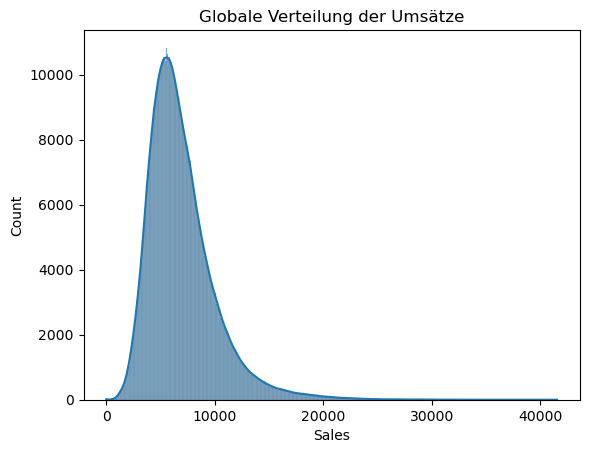

In [12]:
sns.histplot(sales_open_df['Sales'], kde=True).set(title="Globale Verteilung der Umsätze");

In [13]:
sales_mean = sales_open_df['Sales'].mean()
sales_std = sales_open_df['Sales'].std()
high_sales = sales_mean + 3*sales_std
sales_high_df = sales_open_df[sales_open_df['Sales'] > high_sales]

print("Durchschnittlicher Umsatz: {:.2f} Euro".format(sales_mean))
print("Standard Abweichung (wie weit die einzelnen Punkte im Durchschnitt vom Mittelwert entfernt sind): {:.2f} Euro".format(sales_std))
print("Anzahl der Datenpunkte, die Umsätze um mehr als drei Standardabweichungen über dem Durchschnitt aufweisen \n(>{:.2f} Euro): {}"
      .format(high_sales, len(sales_high_df)))

Durchschnittlicher Umsatz: 6955.51 Euro
Standard Abweichung (wie weit die einzelnen Punkte im Durchschnitt vom Mittelwert entfernt sind): 3104.21 Euro
Anzahl der Datenpunkte, die Umsätze um mehr als drei Standardabweichungen über dem Durchschnitt aufweisen 
(>16268.16 Euro): 13437


Wir können feststellen, dass es Filialen gibt, die (sehr) oft Umsätze weit über dem Durchschnitt erzielen. Dies legt nahe, dass die Spitzenwerte der Umsätze mit den allgemeinen (vielleicht manchmal externen?) Bedingungen der jeweiligen Filialen zu tun haben.

In [14]:
outlier_stores = pd.DataFrame(sales_high_df.groupby('Store').size().sort_values(ascending=False)
                              .rename("NoDaysWithVeryHighSales"))
outlier_stores[:10]

,NoDaysWithVeryHighSales
Store,
262,842
1114,734
562,684
817,667
251,614
513,544
788,512
383,488
842,449


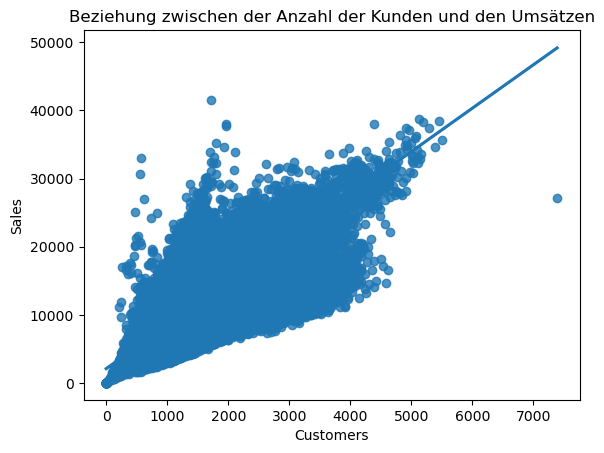

In [15]:
sns.regplot(x='Customers', y='Sales', data=sales_open_df).set(title="Beziehung zwischen der Anzahl der Kunden und den Umsätzen");

Wie erwartet, besteht eine positive Korrelation zwischen diesen beiden Variablen.

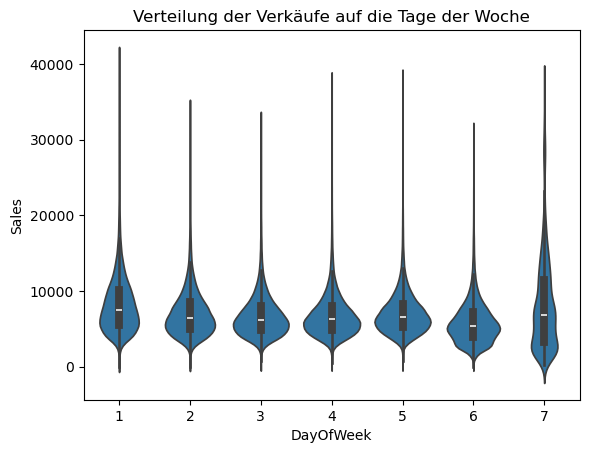

In [16]:
sns.violinplot(data=sales_open_df, x='DayOfWeek', y='Sales').set(title="Verteilung der Verkäufe auf die Tage der Woche");

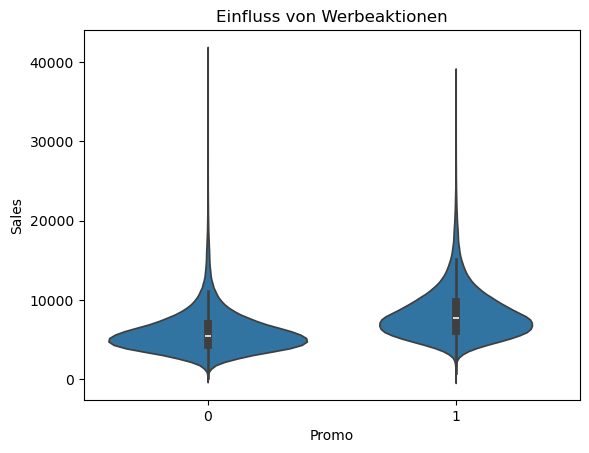

In [17]:
sns.violinplot(data=sales_open_df, x='Promo', y='Sales').set(title="Einfluss von Werbeaktionen");

Wir sehen, dass der Durchschnittsumsatz höher ist, wenn es Werbeaktionen gibt. Die Spitzenwerte der Umsätze scheinen jedoch unabhängig von Werbeaktionen zu sein.

##### Zusammenhang zwischen den verschiedenen Arten von Feiertagen und den Umsätzen

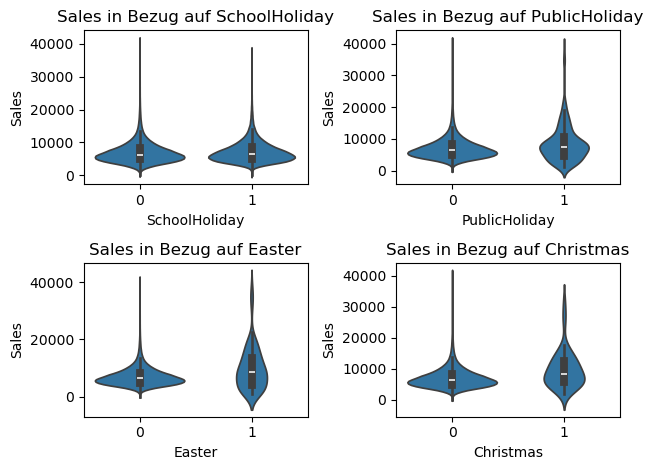

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)    
axes = axes.flatten()
cols = ['SchoolHoliday', 'PublicHoliday', 'Easter', 'Christmas']

for ax, col in zip(axes, cols):
    sns.violinplot(data=sales_open_df, x=col, y='Sales', ax=ax)
    ax.set_title("Sales in Bezug auf {}".format(col))

fig.tight_layout();

- Ob es Schulferien gibt oder nicht, hat anscheinend keinen großen Einfluss auf die globale Verteilung der Umsätze. Ich werde dies im Hinterkopf behalten wenn ich die Variablen für die Modelle auswähle.
- In den übrigen Arten von Feiertagen ist die Verteilung der Verkäufe breiter gestreut.